In [1]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
# import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [2]:
fn_basin = '../GlacierLakeDetectionICESat2/basins/shapefiles/Basins_Antarctica_v02.shp'
fn_coast = '../GlacierLakeDetectionICESat2/basins/shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = '../GlacierLakeDetectionICESat2/basins/shapefiles/GroundingLine_Antarctica_v02.shp'
fn_merged =  '../GlacierLakeDetectionICESat2/basins/shapefiles/ANT_basins_merged.shp'

ant_gdf_basin = gpd.read_file(fn_basin)
ant_gdf_coast = gpd.read_file(fn_coast)
ant_gdf_ground = gpd.read_file(fn_ground)
ant_gdf_merged = gpd.read_file(fn_merged)

fn_basin = '../GlacierLakeDetectionICESat2/basins/shapefiles/Greenland_Basins_PS_v1.4.2.shp'
fn_merged = '../GlacierLakeDetectionICESat2/basins/shapefiles/GRE_basins_merged.shp'
gre_gdf_basin = gpd.read_file(fn_basin)
gre_gdf_basin['geometry'] = gre_gdf_basin.geometry.buffer(3)
gre_gdf_merged = gpd.read_file(fn_merged)

gre_bound = gre_gdf_basin.dissolve().boundary
ant_bound = ant_gdf_basin.dissolve().boundary

In [21]:
df_lakes.groupby('ice_sheet')['max_depth'].max().rename('depth_max')
# df_lakes.groupby('ice_sheet')[['max_depth']].apply(lambda x: np.percentile(x,90)).rename('depth90')

ice_sheet
AIS     19.600850
GrIS    28.616643
Name: depth_max, dtype: float64

In [22]:
fn_granule_stats = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_granulestats_for-wais_ross-fix_gooddata.csv'
df_stats = pd.read_csv(fn_granule_stats)
df_stats.loc[np.isnan(df_stats.percentage_xatc), 'percentage_xatc'] = 0
df_stats['percentage'] = df_stats.apply(lambda x: '%.2g%%' % x.percentage_xatc, axis=1)
df_stats.rename(columns={'Unnamed: 0':'region'}, inplace=True)
out_path_csv = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fix_gooddata.csv'
df_lakes = pd.read_csv(out_path_csv)
df_lakes['basin_name'] = df_lakes.apply(lambda x: x.basin_name.split('_')[-1], axis=1)

# 90th percentile lakes
s1 = df_lakes.groupby('ice_sheet')[['max_depth']].apply(lambda x: np.percentile(x,90)).rename('depth90')
s2 = df_lakes.groupby('main_region')[['max_depth']].apply(lambda x: np.percentile(x,90)).rename('depth90')
s3 = df_lakes.groupby('basin_name')[['max_depth']].apply(lambda x: np.percentile(x,90)).rename('depth90')
depthdf = pd.DataFrame(pd.concat((s1,s2, s3))).reset_index().rename(columns={'index': 'region'})
df_stats = df_stats.merge(depthdf, on='region', how='left')
df_stats.loc[np.isnan(df_stats.depth90), 'depth90'] = 0
df_stats['depth'] = df_stats.apply(lambda x: '%.1f m' % x.depth90, axis=1)

s1 = df_lakes.groupby('ice_sheet')['max_depth'].max().rename('depth_max')
s2 = df_lakes.groupby('main_region')['max_depth'].max().rename('depth_max')
s3 = df_lakes.groupby('basin_name')['max_depth'].max().rename('depth_max')
depthdf = pd.DataFrame(pd.concat((s1,s2, s3))).reset_index().rename(columns={'index': 'region'})
df_stats = df_stats.merge(depthdf, on='region', how='left')
df_stats.loc[np.isnan(df_stats.depth_max), 'depth_max'] = 0
df_stats['depth_max_str'] = df_stats.apply(lambda x: '%.1f m' % x.depth_max, axis=1)

ant_stats = ant_gdf_merged.rename(columns={'Subregions':'region'}).merge(df_stats, on='region', how='left')
gre_stats = gre_gdf_merged.rename(columns={'SUBREGION1':'region'}).merge(df_stats, on='region', how='left')

In [23]:
def print_stats(df, stat, ax):
    fs1 = 9
    fs2 = 9
    text_locs = {
        'Dp-E': {'x_arr': -128147.712, 'y_arr': -2032767.364},
        'F-G': {'x_arr': -769669.550, 'y_arr': -1648518.481},
        'G-H': {'x_arr': -2495373.673, 'y_arr': -468117.194},
        'H-Hp': {'x_arr': -2479420.923, 'y_arr': 60005.141},
        'Hp-I': {'x_arr': -2674457.410, 'y_arr': 598677.356},
        'I-Ipp': {'x_arr': -2727320.425, 'y_arr': 1827686.970},
        'Ipp-J': {'x_arr': -1775122.496, 'y_arr': 1609461.681},
        'K-A': {'x_arr': -1168342.312, 'y_arr': 2124915.231},
        'SW': {'x_arr': -462963.464, 'y_arr': -3232377.745},
        'SE': {'x_arr': 524452.543, 'y_arr': -3037332.608},
        'NW': {'x_arr': -115775.860, 'y_arr': -1595145.186},
    }
    for i in range(len(df)):
        x = df.iloc[i]
        arrlocs = text_locs[x.region] if x.region in text_locs.keys() else None
        color = 'k' if x.region in text_locs.keys() else x.color_text
        locs = x.geometry.centroid.coords[0]
        if arrlocs:
            xyarr = [arrlocs['x_arr'], arrlocs['y_arr']]
            frac = 0.4
            xystart = np.array(xyarr) + frac*(np.array(locs) - np.array(xyarr)) 
            if x.region != 'NW':
                ax.annotate('', xy=locs, xytext=xystart, ha='center',va='center',color='k',fontsize=fs1,
                         arrowprops=dict(width=0.5, headwidth=4, headlength=4, color='k'),zorder=1000)
            ax.text(arrlocs['x_arr'], arrlocs['y_arr'], x.region, ha='center',va='bottom', color=color, fontsize=fs2, weight='bold')
            ax.text(arrlocs['x_arr'], arrlocs['y_arr'], x[stat], ha='center',va='top', color=color, fontsize=fs2, weight='bold')
        else:
            ax.text(locs[0], locs[1], x.region, ha='center',va='bottom', color=color, fontsize=fs1, weight='bold')
            ax.text(locs[0], locs[1], x[stat], ha='center',va='top', color=color, fontsize=fs2, weight='bold')
        

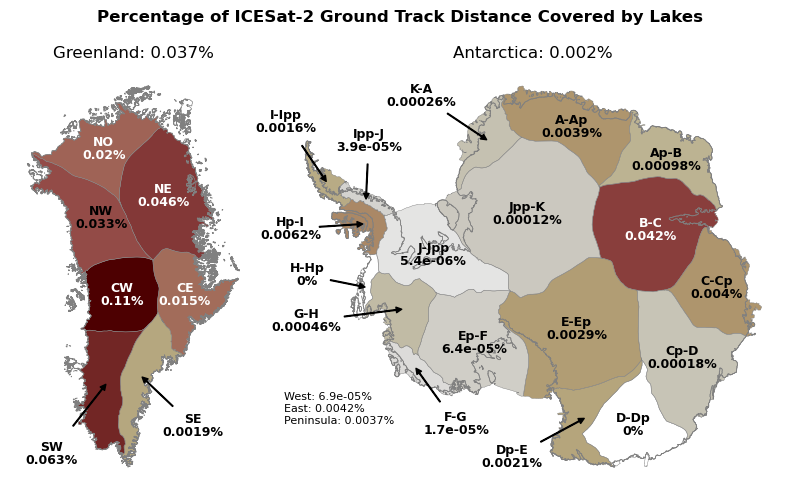

In [10]:
##########################################
# GREENLAND MAP
stat = 'percentage'

ant_stats['color_vals'] = ant_stats.percentage_xatc**(1/4)
gre_stats['color_vals'] = gre_stats.percentage_xatc**(1/4)
vmax = np.max((ant_stats.color_vals.max(), gre_stats.color_vals.max()))
ant_stats['color_text'] = ant_stats.apply(lambda x: 'black' if x.color_vals<(vmax/2) else 'white', axis=1)
gre_stats['color_text'] = gre_stats.apply(lambda x: 'black' if x.color_vals<(vmax/2) else 'white', axis=1)

fig = plt.figure(figsize=[8,5])
gs = fig.add_gridspec(1, 3)
axs = []
axs.append(fig.add_subplot(gs[0, 0])) # greenland
axs.append(fig.add_subplot(gs[0, 1:])) # antarctica
ax = axs[0]
gre_stats.plot(column='color_vals', ax=ax, cmap=cmc.bilbao, vmin=0, vmax=vmax)
gre_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.3)
gre_bound.plot(color='gray', ax=ax, lw=0.5)

print_stats(gre_stats, stat=stat, ax=ax)
ax.set_title('\nGreenland: %s' % df_stats.loc[df_stats.region == 'GrIS', stat].iloc[0])


ax.axis('off')

##########################################
# ANTARCTICA MAP
ax = axs[1]

ant_stats.plot(column='color_vals', ax=ax, cmap=cmc.bilbao, vmin=0, vmax=vmax)
ant_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.3)
ant_gdf_ground.boundary.plot(color='gray', ax=ax, lw=0.5)
ant_bound.plot(color='gray', ax=ax, lw=0.5)

print_stats(ant_stats, stat=stat, ax=ax)
ax.set_title('\nAntarctica: %s' % df_stats.loc[df_stats.region == 'AIS', stat].iloc[0])
text = '%s: %s\n%s: %s\n%s: %s' % ('West', df_stats.loc[df_stats.region == 'AIS_West', stat].iloc[0],
                                      'East', df_stats.loc[df_stats.region == 'AIS_East', stat].iloc[0],
                                      'Peninsula', df_stats.loc[df_stats.region == 'AIS_Peninsula', stat].iloc[0])
ax.text(-2746800.763, -1477090.919, text, ha='left', va='center', fontsize=8)

ax.axis('off')
fig.suptitle('Percentage of ICESat-2 Ground Track Distance Covered by Lakes', fontweight='bold')
fig.tight_layout(pad=1, h_pad=0, w_pad=0)

fig.savefig('plots/xatc_percentage.jpg', dpi=600)

# to get coordinates from clicks
coords = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("'x': %.3f, 'y': %.3f" % (ix,iy))
    global coords
    coords.append((ix,iy))
    if len(coords) > 100:
        fig.canvas.mpl_disconnect(cid)
    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [6]:
region = 'NW'
print("'%s': {'x_arr': %.3f, 'y_arr': %.3f}," % (region, coords[-1][0], coords[-1][1]))

'NW': {'x_arr': -115775.860, 'y_arr': -1595145.186},


In [38]:
# df_lakes.groupby('main_region')['lake_id'].count()
print('filelst = [')
for i in range(5):
    fn = df_lakes[df_lakes.main_region=='AIS_Peninsula'].sort_values('max_depth',ascending=False).iloc[i].file_name
    print("'",fn,"',",sep='')
print(']')

filelst = [
'/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/lake_09999733_AIS_2019-20_simplified_ANT_1000_Peninsula_Hp-I_ATL03_20200204213749_06130612_006_01_gt3l_0053.h5',
'/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/lake_09999905_AIS_2022-23_simplified_ANT_1000_Peninsula_Hp-I_ATL03_20230129173611_06131812_006_01_gt1l_0002.h5',
'/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/lake_09955969_AIS_2020-21_simplified_ANT_1000_Peninsula_Hp-I_ATL03_20210213150425_07881010_006_01_gt1r_0001.h5',
'/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/lake_09998273_AIS_2019-20_simplified_ANT_1000_Peninsula_Hp-I_ATL03_20200106230147_01710612_006_01_gt3l_0006.h5',
'/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/lake_09999182_AIS_2022-23_simplified_ANT_1000_Peninsula_I-Ipp_ATL03_20230220160301_09481812_006_01_gt2l_0000.h5',
]


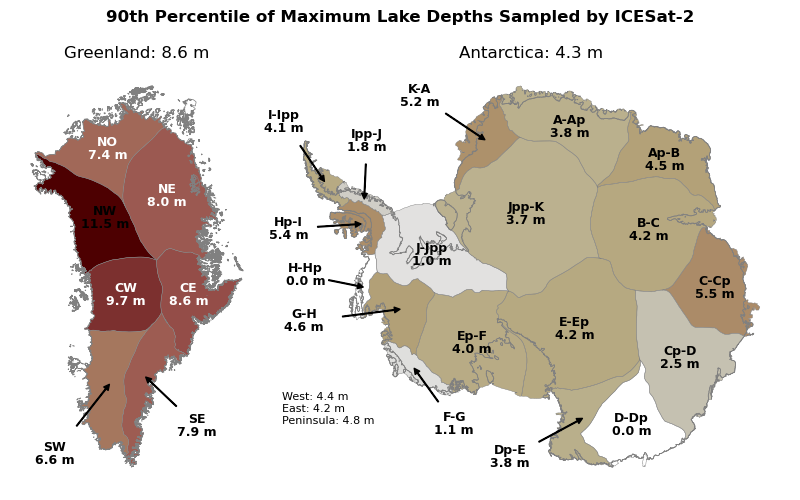

In [11]:
##########################################
# GREENLAND MAP
stat = 'depth'

ant_stats['color_vals'] = ant_stats.depth90
gre_stats['color_vals'] = gre_stats.depth90
vmax = np.max((ant_stats.color_vals.max(), gre_stats.color_vals.max()))
ant_stats['color_text'] = ant_stats.apply(lambda x: 'black' if x.color_vals<(vmax/2) else 'white', axis=1)
gre_stats['color_text'] = gre_stats.apply(lambda x: 'black' if x.color_vals<(vmax/2) else 'white', axis=1)

fig = plt.figure(figsize=[8,5])
gs = fig.add_gridspec(1, 3)
axs = []
axs.append(fig.add_subplot(gs[0, 0])) # greenland
axs.append(fig.add_subplot(gs[0, 1:])) # antarctica
ax = axs[0]
gre_stats.plot(column='color_vals', ax=ax, cmap=cmc.bilbao, vmin=0, vmax=vmax)
gre_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.3)
gre_bound.plot(color='gray', ax=ax, lw=0.5)

print_stats(gre_stats, stat=stat, ax=ax)
ax.set_title('\nGreenland: %s' % df_stats.loc[df_stats.region == 'GrIS', stat].iloc[0])


ax.axis('off')

##########################################
# ANTARCTICA MAP
ax = axs[1]

ant_stats.plot(column='color_vals', ax=ax, cmap=cmc.bilbao, vmin=0, vmax=vmax)
ant_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.3)
ant_gdf_ground.boundary.plot(color='gray', ax=ax, lw=0.5)
ant_bound.plot(color='gray', ax=ax, lw=0.5)

print_stats(ant_stats, stat=stat, ax=ax)
ax.set_title('\nAntarctica: %s' % df_stats.loc[df_stats.region == 'AIS', stat].iloc[0])
text = '%s: %s\n%s: %s\n%s: %s' % ('West', df_stats.loc[df_stats.region == 'AIS_West', stat].iloc[0],
                                      'East', df_stats.loc[df_stats.region == 'AIS_East', stat].iloc[0],
                                      'Peninsula', df_stats.loc[df_stats.region == 'AIS_Peninsula', stat].iloc[0])
ax.text(-2746800.763, -1477090.919, text, ha='left', va='center', fontsize=8)

ax.axis('off')
fig.suptitle('90th Percentile of Maximum Lake Depths Sampled by ICESat-2', fontweight='bold')
fig.tight_layout(pad=1, h_pad=0, w_pad=0)

fig.savefig('plots/depth_map_90th_perc.jpg', dpi=600)